# Fast Lomb-Scargle Periodograms in Python

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2015/06/13/lomb-scargle-in-python/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.*

<!-- PELICAN_BEGIN_SUMMARY -->

<div style="float: right; margin-top: 10px; margin-bottom: 50px; width: 280px; height: 240px; margin: 10px;">
<center>
<a href="http://www.astroml.org/_images/fig_LS_example_1.png"><img src="http://www.astroml.org/_images/fig_LS_example_1.png"></a>
<small>Image source: astroML. Source code <a href="http://www.astroml.org/book_figures/chapter10/fig_LS_example.html#book-fig-chapter10-fig-ls-example">here</a></small>
</center>
</div>

*Edit, Spring 2017: For an in-depth guide to the practical use of Lomb-Scargle periodograms, see the paper discussed in [A Practical Guide to the Lomb-Scargle Periodogram](http://jakevdp.github.io/blog/2017/03/30/practical-lomb-scargle/).*

*Edit, Summer 2016: All of the implementations discussed below have been added to [AstroPy](http://astropy.org) as of Version 1.2, along with logic to choose the optimal implementation automatically. Read more here: [``astropy.stats.LombScargle``](http://astropy.readthedocs.io/en/latest/stats/lombscargle.html).*

The Lomb-Scargle periodogram (named for [Lomb (1976)](http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L) and [Scargle (1982)](http://adsabs.harvard.edu/abs/1982ApJ...263..835S)) is a classic method for finding periodicity in irregularly-sampled data.
It is in many ways analogous to the more familiar Fourier Power Spectral Density (PSD) often used for detecting periodicity in regularly-sampled data.

Despite the importance of this method, until recently there have not been any (in my opinion) solid implementations of the algorithm available for easy use in Python.
That has changed with the introduction of the [gatspy](http://astroml.org/gatspy/) package, which I recently released.
In this post, I will compare several available Python implementations of the Lomb-Scargle periodogram, and discuss some of the considerations required when using it to analyze data.

To cut to the chase, I'd recommend using the [gatspy](http://astroml.org/gatspy/) package for Lomb-Scargle periodograms in Python, and particularly its ``gatspy.periodic.LombScargleFast`` algorithm which implements an efficient pure-Python version of Press & Rybicki's $O[N\log N]$ periodogram.
Below, I'll dive into the reasons for this recommendation.

<!-- PELICAN_END_SUMMARY -->

## Example: Lomb-Scargle on Variable Stars

As an motivation, let's briefly consider some data from my own field: observations of an [*RR Lyrae-type*](https://en.wikipedia.org/wiki/RR_Lyrae_variable) variable star.
RR Lyrae are small stars – about 50% the mass of our sun – which pulsate with a regular period on order half a day.
Their relatively consistent peak intrinsic brightness allows for an accurate estimation of their distance from the sun, and thus they are important for studies such as [understanding the substructure](http://www.mpia.de/~bsesar/media.html) of the Milky Way galaxy.
Because of this and other similar applications, detecting the telltale periodic variation of RR Lyrae stars within noisy data is an important statistical task for astronomers.

Here we will quickly demonstrate what this looks like in practice, using tools from the [astroML](http://astroML.org) package to download some data, and tools from the [gatspy](http://astroml.org/gatspy/) package to detect the periodicity.

We'll start with some typical Python import statements:

In [1]:
# Do preliminary imports and notebook setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# use seaborn for plot styles
import seaborn; seaborn.set()

Now we'll download some data from the [LINEAR](https://en.wikipedia.org/wiki/Lincoln_Near-Earth_Asteroid_Research) dataset, using tools in astroML.
We'll plot the data to see what we're working with:

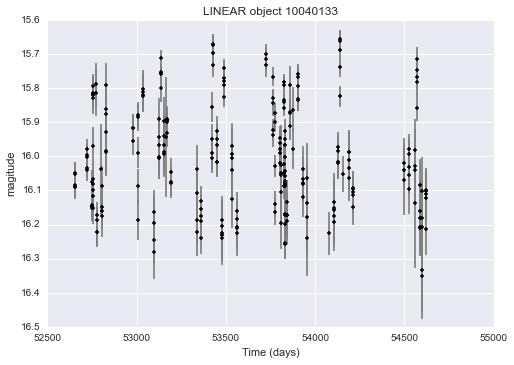

In [2]:
from astroML.datasets import fetch_LINEAR_sample
LINEAR_data = fetch_LINEAR_sample()
star_id = 10040133
t, mag, dmag = LINEAR_data.get_light_curve(star_id).T

fig, ax = plt.subplots()
ax.errorbar(t, mag, dmag, fmt='.k', ecolor='gray')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(star_id))
ax.invert_yaxis();

This data has around 250 observations spread across about 2000 days, and we're hoping to detect a period of order 0.5 days.
If the series were regularly-sampled, we'd be far above the Nyquist limit and all hope would be lost.
Fortunately for astronomers, the assumptions behind the Nyquist sampling limit do not hold for irregular sampling rates, and we can proceed with no problem.

Let's start by computing and plotting the Lomb-Scargle Periodogram for this data, using tools from gatspy:

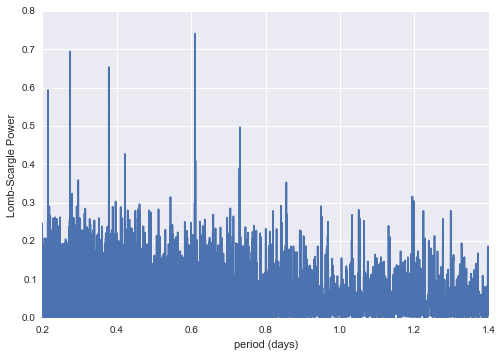

In [3]:
from gatspy.periodic import LombScargleFast
model = LombScargleFast().fit(t, mag, dmag)
periods, power = model.periodogram_auto(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0.2, 1.4), ylim=(0, 0.8),
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power');

The periodogram gives a measure of periodic content as a function of period; we see here a strong peak at around 0.61 days.
Other lower peaks are due to some combination of higher-order harmonics in the data and effects of the irregular survey window.
While we could find this maximum manually from the above grid, ``gatspy`` provides a better way: a built-in two-stage grid-search that accurately determines the best period in a specified range:

In [4]:
# set range and find period
model.optimizer.period_range=(0.2, 1.4)
period = model.best_period
print("period = {0}".format(period))

Finding optimal frequency:
 - Estimated peak width = 0.0032
 - Using 5 steps per peak; omega_step = 0.00064
 - User-specified period range:  0.2 to 1.4
 - Computing periods at 42104 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 0.6105387801103276


We see that the optimizer determined that it needed a grid of over 40,000 points to adequately cover the frequency grid (more on this below), and in the end arrived at a best period of 0.6105 days.
Given this detected period, we can fold the input data and over-plot a best-fit empirical RR Lyrae template to see the fit:

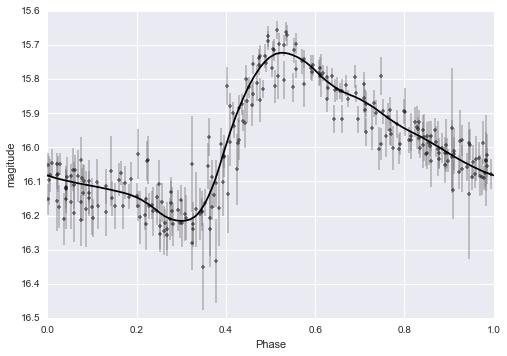

In [5]:
# Compute phases of the obsevations
phase = (t / period) % 1

# Compute best-fit RR Lyrae template
from gatspy.periodic import RRLyraeTemplateModeler
model = RRLyraeTemplateModeler('r').fit(t, mag, dmag)
phase_fit = np.linspace(0, 1, 1000)
mag_fit = model.predict(period * phase_fit, period=period)

# Plot the phased data & model
fig, ax = plt.subplots()
ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
ax.plot(phase_fit, mag_fit, '-k')
ax.set(xlabel='Phase', ylabel='magitude')
ax.invert_yaxis();

This very close template fit gives a strong indication that the star in question is an RR Lyrae.

## Computational Considerations for Lomb-Scargle

The Lomb-Scargle periodogram involves the computation of a power $P(\omega)$ at a set of frequencies $\omega_i$.
For data $\{y_k\}$ pre-centered such that $\sum_k y_k = 0$, the expression for the power is:

$$
P(\omega) \propto
  \frac{\left[\sum_k y_k \cos\omega(t_k - \tau)\right]^2}
    {\sum_k \cos^2\omega(t_k - \tau)} +
  \frac{\left[\sum_k y_k \sin\omega(t_k - \tau)\right]^2}
    {\sum_k \sin^2\omega(t_k - \tau)}
$$

where $\tau$ is an easily computed time-offset which orthogonalizes the model and makes $P(\omega)$ independent of a translation in $t$.

Rather than get lost in the math, I want to emphasize the key feature of this expression: **for any frequency $\omega$, the power is an $O[N]$ computation involving simple trigonometric sums over the data,** where $N$ is the number of observed data points.
The main computational question then becomes: how many frequencies must you compute?
In my experience, the most common mistake people make when doing this sort of periodic analysis is not thinking hard enough about the frequency grid.
It turns out that the grid-spacing question is *very* important.
If you choose too fine a grid, you do much more computation than is required.
Worse, if you choose too coarse a grid, the periodogram peak may fall between grid points and you'll miss it entirely!

Let's think about the required frequency range and frequency spacing for Lomb-Scargle.

### Frequency spacing

First we'll choose the spacing of the frequency grid.
If you're asking about a candidate frequency $f$, then data with range $T = t_{max} - t_{min}$ contains $T \cdot f$ complete cycles. If our error in frequency is $\delta f$, then $T\cdot\delta f$ is the error in number of cycles between the endpoints of the data.
It's clear that this error must not be a significant fraction of a cycle, or the fit could be drastically affected.
This leads to an approximate grid-spacing criterion:

$$
T\cdot\delta f \ll 1
$$

Commonly, we'll choose some oversampling factor (say, 5) and use $\delta f = (5T)^{-1}$ as our frequency grid spacing.

### Frequency limits

Next, we need to choose the upper and lower limits of the frequency grid. On the low end, $f=0$ is suitable, but causes some numerical problems – we'll go one step away and use $\delta f$ as our minimum frequency.
But on the high end, we need to make a choice: what's the highest frequency we'd trust our data to be sensitive to?
At this point, many people are tempted to mis-apply the Nyquist-Shannon sampling theorem, and choose some version of the Nyquist limit for the data (based on, say, the minimum or mean spacing between observations).
But this is entirely wrong! The Nyquist frequency is derived from special properties of regularly-sampled data, and does not apply – even approximately – to irregularly-sampled time-series.
In fact, as we saw above, irregularly-sampled data can be sensitive to much, much higher frequencies than even the minimum spacing between observations.
With this in mind, the upper limit for frequencies should be determined based on **what kind of signal you are looking for.**

Still, a common (if dubious) rule-of-thumb is that the high frequency is some multiple of what Press & Rybicki call the "average" Nyquist frequency,

$$
\hat{f}_{Ny} = \frac{N}{2T}
$$

This means that the "typical" number of frequencies you'll need is

$$
N_{freq} \sim O\left[\frac{\hat{f}_{Ny}}{\delta f}\right] \sim O\left[\frac{N/(2T)}{1/T}\right] \sim O[N]
$$

That is, the number of frequencies to search will scale with the number of data points!

### Computational Complexity

From the above considerations, we see that the determination of the optimal Lomb-Scargle period within $N$ points requires computing an $O[N]$ expression for power across $O[N]$ grid points; that is, Lomb-Scargle is naively an $O[N^2]$ algorithm.

This computational complexity can be improved in one of several ways.
Most notably, in a [1989 paper](http://adsabs.harvard.edu/full/1989ApJ...338..277P), Press and Rybicki proposed a clever method whereby a Fast Fourier Transform is used on a grid *extirpolated* from the original data, such that this naively $O[N^2]$ problem can be solved in $O[N\log N]$ time.
The broad idea is that when you compute sums of sines and cosines for one frequency, this gives you some amount of information about those sums computed at another frequency, and by carefully using all information across a frequency grid, you can significantly reduce the number of required operations.

Thus the fundamental divide between Lomb-Scargle implementations is whether they use the naive $O[N^2]$ algorithm or the $O[N\log N]$ algorithm of Press & Rybicki and other similar approaches.

## Lomb-Scargle Algorithms in Python

Now we get to the meat of this post: Lomb-Scargle implementations written in Python.
If you search this on Google, you'll currently find links to several available implementations.
Here I'm going to delve into and compare the following four implementations:

- ``scipy.signal.lombscargle``, an $O[N^2]$ implementation from [SciPy](http://docs.scipy.org/doc/scipy/reference/).
- ``astroML.time_series.lomb_scargle``, an $O[N^2]$ implementation from [astroML](http://astroML.org/).
- ``gatspy.periodic.LombScargle``, an $O[N^2]$ implementation from [gatspy](http://astroml.org/gatspy/).
- ``gatspy.periodic.LombScargleFast``, an $O[N\log N]$ implementation, also from [gatspy](http://astroml.org/gatspy/).

Let's see some examples of the above tools:

#### ``scipy.signal.lombscargle``

The SciPy Lomb-Scargle periodogram is a C implementation of the naive $O[N^2]$ algorithm.
The algorithm cannot account for noise in the data, and has some other quirks as well:

- it requires you to center your data (by subtracting the mean) before computing the periodogram. If you do not, the results will be garbage.
- it computes the unnormalized periodogram, which can be normalized manually as we'll see below.
- it takes *angular frequencies* as the argument.

Let's use scipy's algorithm to plot the periodogram of the data shown above.
Note that the results will not be identical, because this algorithm ignores the noise in the data and doesn't fit for the data mean.

Against the above recommendations, we'll choose a simple regular grid in period for the plot:

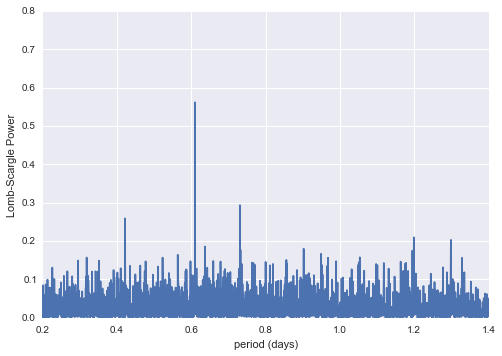

In [6]:
from scipy.signal import lombscargle

# Choose a period grid
periods = np.linspace(0.2, 1.4, 4000)
ang_freqs = 2 * np.pi / periods

# compute the (unnormalized) periodogram
# note pre-centering of y values!
power = lombscargle(t, mag - mag.mean(), ang_freqs)

# normalize the power
N = len(t)
power *= 2 / (N * mag.std() ** 2)

# plot the results
fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(ylim=(0, 0.8), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');

Comparing to the first periodogram plot, we see that becuase our period grid here is too coarse at low frequencies, some of the peak structure is missed by this visualization.
Consider this a warning against arbitrarily choosing a period gridding!

#### ``astroML.time_series.lomb_scargle``

AstroML has two $O[N^2]$ implementations of Lomb-Scargle: one in ``astroML`` and one in ``astroML_addons``, which is a collection of C extensions which replace slower functionality in the pure-python astroML package.
In order to use the faster version, make sure you install both packages; e.g.

```
$ pip install astroML
$ pip install astroML_addons
```

Some important features of astroML's Lomb Scargle periodogram:

- unlike scipy, it uses an extended periodogram model which can correctly account for uncorrelated Gaussian measurement error.
- like scipy, it takes *angular frequencies* as its argument.
- unlike scipy, it implements a *floating mean periodogram*, meaning that the data centering required for scipy is not required here, but it goes beyond simple centering: the mean of the data is fit *as part of the model*, which has advantages in many real-world scenarios. To directly compare to scipy's standard Lomb Scargle pass ``generalized=False``.

Let's repeat the above plot with this periodogram:

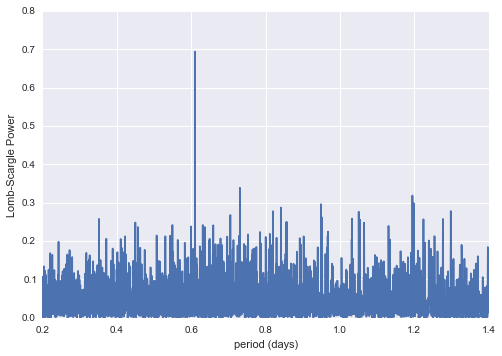

In [7]:
from astroML.time_series import lomb_scargle
power = lomb_scargle(t, mag, dmag, ang_freqs)

# plot the results
fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(ylim=(0, 0.8), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');

#### ``gatspy.periodic.LombScargle``

Gatspy's basic Lomb-Scargle algorithm is an $O[N^2]$ implementation, but is implemented differently than either of the above versions.
It uses a direct linear algebra approach which carries some additional computational and memory overhead.
The reason for this approach is that it naturally accommodates several extensions to the periodogram, including floating mean, multiple terms, regularization, and multi-band models (more details in [VanderPlas & Ivezic (2015)](http://adsabs.harvard.edu/abs/2015arXiv150201344V), the paper that inspired ``gatspy``).

Gatspy is a pure python package, and thus installation is easy and requires no compilation of C or Fortran code:

```
$ pip install gatspy
```

Some important features of this implementation:

- like astroML, it uses an extended periodogram model which correctly accounts for uncorrelated Gaussian measurement error.
- unlike astroML, it takes *periods* as its argument.
- like astroML, it uses a floating mean model by default. To compare directly to scipy's non-floating-mean model, set ``fit_offset=False``.
- it has an API inspired by scikit-learn, where the model itself is a class instance, the model is applied to data with a ``fit()`` method, and the periodogram is computed via a ``score()`` method.

Let's repeat the above periodogram using this tool:

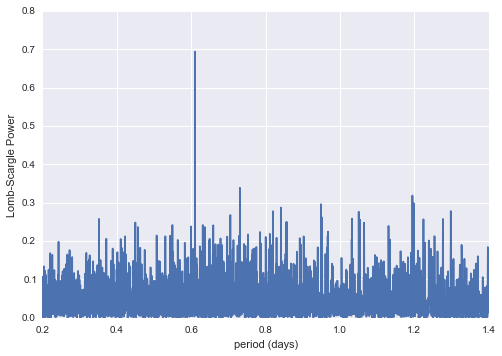

In [8]:
from gatspy.periodic import LombScargle

model = LombScargle(fit_offset=True).fit(t, mag, dmag)
power = model.score(periods)

# plot the results
fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(ylim=(0, 0.8), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');

#### ``gatspy.periodic.LombScargleFast``

Gatspy's fast Lomb-Scargle is an $O[N\log N]$ algorithm built on a pure Python/numpy implementation of the Press & Rybicki FFT/extirpolation method.
Note that a requirement of this fast algorithm is that it be computed on a regular grid of *frequencies* (not periods), and so to attain this performance it provides the ``score_frequency_grid()`` method which takes 3 arguments: the minimum frequency ``f0``, the frequency spacing ``df``, and the number of grid points ``N``.

Some features of the model

- like astroML, it uses an extended periodogram model which correctly accounts for uncorrelated Gaussian measurement error.
- it takes *a regular frequency grid* as its argument for the fast computation; note that the ``score()`` function itself falls back on the slower ``LombScargle`` approach above.
- like astroML, it uses a floating mean model by default. To compare directly to scipy, set ``fit_offset=False``.
- it has an identical API to the ``LombScargle`` object above.

Let's take a look at computing the periodogram:

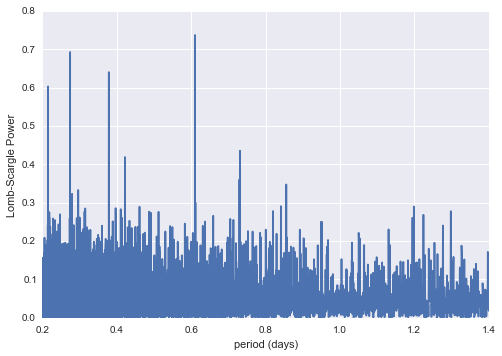

In [9]:
from gatspy.periodic import LombScargleFast

fmin = 1. / periods.max()
fmax = 1. / periods.min()
N = 10000
df = (fmax - fmin) / N

model = LombScargleFast().fit(t, mag, dmag)
power = model.score_frequency_grid(fmin, df, N)
freqs = fmin + df * np.arange(N)

# plot the results
fig, ax = plt.subplots()
ax.plot(1. / freqs, power)
ax.set(ylim=(0, 0.8), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');

You'll notice here that this approach shows a lot more high-frequency peaks than any of the above versions.
This is not because it is computing a different model; it is because we are using a finer frequency grid which does not miss these peaks.
The above versions, with a regular grid of 4000 periods *miss these important features*, and give the user absolutely no warning that these features are missed!
Keep this in mind as you choose grid parameters while following the above discussion.

If you want to make sure you're using a sufficient grid, you can use the ``periodogram_auto()`` method of ``LombScargleFast``, which computes a sufficient frequency grid for you using the rules-of-thumb discussed in the previous section:

In [10]:
model = LombScargleFast().fit(t, mag, dmag)

period, power = model.periodogram_auto(nyquist_factor=200)

print("period range: ({0}, {1})".format(period.min(), period.max()))
print("number of periods: {0}".format(len(period)))

period range: (0.0764511670428014, 9823.97496499998)
number of periods: 128500


The model decided that we needed over 100,000 periods, between about 0.1 days (which was tuned by the ``nyquist_factor`` argument) and about 10,000 days (which is derived from the time-span of the data). Plotting the results as above, we see a similar periodogram:

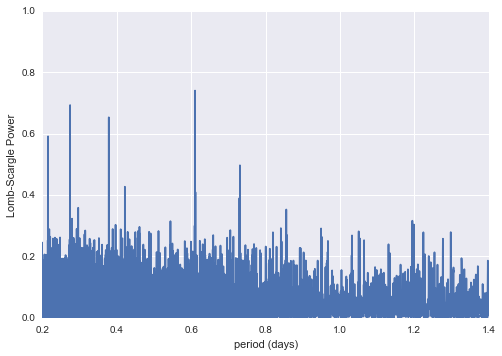

In [11]:
# plot the results
fig, ax = plt.subplots()
ax.plot(period, power)
ax.set(xlim=(0.2, 1.4), ylim=(0, 1.0),
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power');

The ``LombScargleFast`` algorithm computes these $10^5$ periodogram steps very quickly; I wouldn't suggest any of the other methods with a grid of this size!

## Benchmarking Lomb-Scargle Implementations

As a final piece of the picture, let's compare the execution speed of the four approaches.
We can do this with IPython's ``%timeit`` magic function using the following script.
Note that this script will take several minutes to run, as it automatically does multiple passes of each benchmark to minimize system timing variation.
For efficiency, we cut-off the slower algorithms at high $N$:

In [12]:
from scipy.signal import lombscargle as ls_scipy
from astroML.time_series import lomb_scargle as ls_astroML

def create_data(N, rseed=0, period=0.61):
    """Create noisy data"""
    rng = np.random.RandomState(rseed)
    t = 52000 + 2000 * rng.rand(N)
    dmag = 0.1 * (1 + rng.rand(N))
    mag = 15 + 0.6 * np.sin(2 * np.pi * t / period) + dmag * rng.randn(N)
    return t, mag, dmag

def compute_frequency_grid(t, oversampling=2):
    """Compute the optimal frequency grid (**not** angular frequencies)"""
    T = t.max() - t.min()
    N = len(t)
    df = 1. / (oversampling * T)
    fmax = N / (2 * T)
    return np.arange(df, fmax, df)

Nrange = 2 ** np.arange(2, 17)
t_scipy = []
t_astroML = []
t_gatspy1 = []
t_gatspy2 = []

for N in Nrange:
    t, mag, dmag = create_data(N)
    freqs = compute_frequency_grid(t)
    periods = 1 / freqs
    ang_freqs = 2 * np.pi * freqs
    f0, df, Nf = freqs[0], freqs[1] - freqs[0], len(freqs)
    
    # Don't compute the slow algorithms at very high N
    if N < 2 ** 15:
        t1 = %timeit -oq ls_scipy(t, mag - mag.mean(), ang_freqs)
        t2 = %timeit -oq ls_astroML(t, mag, dmag, ang_freqs)
        t3 = %timeit -oq LombScargle().fit(t, mag, dmag).score_frequency_grid(f0, df, Nf)
        t_scipy.append(t1.best)
        t_astroML.append(t2.best)
        t_gatspy1.append(t3.best)
    else:
        t_scipy.append(np.nan)
        t_astroML.append(np.nan)
        t_gatspy1.append(np.nan)
        
    t4 = %timeit -oq LombScargleFast().fit(t, mag, dmag).score_frequency_grid(f0, df, Nf)
    t_gatspy2.append(t4.best)

When these timings are finished, we can plot the results to get an idea of how the algorithms compare:

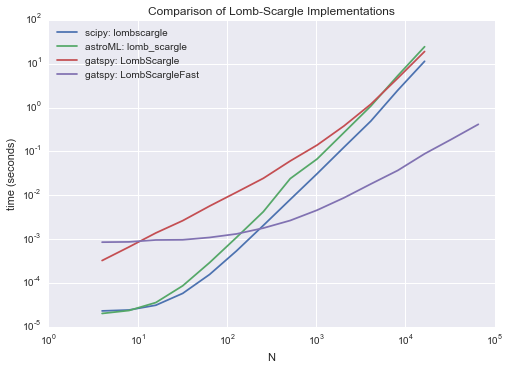

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, xscale='log', yscale='log')
ax.plot(Nrange, t_scipy, label='scipy: lombscargle')
ax.plot(Nrange, t_astroML, label='astroML: lomb_scargle')
ax.plot(Nrange, t_gatspy1, label='gatspy: LombScargle')
ax.plot(Nrange, t_gatspy2, label='gatspy: LombScargleFast')
ax.set(xlabel='N', ylabel='time (seconds)',
       title='Comparison of Lomb-Scargle Implementations')
ax.legend(loc='upper left');

Each model has a characteristic performance curve:

- The **scipy** and **astroML** algorithms show similar behavior: fast $O[1]$ scaling at the small-$N$ limit, and clear $O[N^2]$ scaling at the large-$N$ limit. SciPy is slightly faster, primarily due to the fact that it computes the simpler noiseless non-floating-mean model.
- Gatspy's ``LombScargle`` also becomes $O[N^2]$ at large $N$, but is dominated at small $N$ by an $O[N]$ contribution which comes from allocating & building the matrices associated with its linear algebraic approach. As $N$ grows larger than $\sim 10^4$, however, gatspy's model begins to beat the performance of the other two $O[N^2]$ algorithms.
- Gatspy's ``LombScargleFast`` has an upfront $O[1]$ cost that makes it slower than other approaches at small $N$, but as $N$ grows its $O[N\log N]$ scaling means it dominates the performance of the other approaches by orders of magnitude.

If you'd like to push the speed of the computation even further, there may be some options available.
For example, the [pynfftls](https://pypi.python.org/pypi/pynfftls/) package implements an $O[N\log N]$ Lomb-Scargle based on the NFFT algorithm, which is similar to the NUFFT that I discussed in a [previous post](https://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/).
The ``pynfftls`` installation depends on prior installations of the [NFFT](http://www-user.tu-chemnitz.de/~potts/nfft/download.php) and [FFTW](http://www.fftw.org/) libraries. These libraries are best-in-class implementations of their respective algorithms, and from my past experience with them, I'd expect ``pynfftls`` to be around a factor of 10 faster than ``LombScargleFast`` with the same $O[N\log N]$ scaling.

I should mention that I briefly tried installing ``pynfftls`` for this post, but ran into difficulties with linking the source to the appropriate C headers and library/shared object files.
No doubt with a couple hours of tinkering it could be done, but in a [conda](http://www.continuum.io/blog/conda) world I've found my threshold of tolerance for such installation headaches has gone *way* down.
Package developers take note: in most situations, ease of installation is easily worth a factor of a few in runtime performance.
If any readers want to tackle the comparison between ``LombScargleFast`` and ``pynfftls``, I'd be intrested to learn whether my factor-of-ten intuition is correct!

## Conclusion

If there's anything I want you to take from the above discussion, it's these three points:

- Naive application of Nyquist-style limits to irregularly-sampled data is 100% wrong. Don't be the next person to make this mistake in the published literature! I've been meaning to write a full rant/post on this subject for a while. Perhaps I will someday.
- Selection of period/frequency grids for Lomb-Scargle analysis should not be taken lightly. It's very easy to inadvertently use too coarse of a grid, and entirely miss important periodogram peaks!
- Use ``gatspy.periodic.LombScargleFast`` if you want any easy-to-install means of computing a fast, $O[N\log N]$ Lomb-Scargle periodogram in Python.

*This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/LombScarglePython.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/LombScarglePython.ipynb).*